In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import pandas as pd
import yaml
from liftoff import parse_opts
from argparse import Namespace
import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style()

from sklearn.model_selection import train_test_split
from scipy.stats import entropy

root_dir = os.path.dirname(os.path.dirname(os.path.realpath(".")))
sys.path.append(root_dir)

from common.src.distribution_src import (
    train_net_with_neural_fitting,
    generate_random_policy_transitions,
    generate_transitions_observations,
    TransitionDataset,
    generate_train_test_split_with_valid_path,
    check_path_existence_to_any_terminal,
    get_frequency_scaling, normalize_frequencies,
    make_env
)
from common.src.experiment_utils import setup_logger, seed_everything
from common.src.policy_iteration import random_policy_evaluation_q_stochastic
from common.src.utils import (
    create_random_policy,
    extract_V_from_Q_for_stochastic_policy,
)
from common.src.models import QNET

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def count_occurrences_and_compute_percentage(
    sampled_transitions_list, total_unique_transitions, N
):
    # Count occurrences of each index in the sampled list
    occurrences_count = {}
    for index in sampled_transitions_list:
        occurrences_count[index] = occurrences_count.get(index, 0) + 1

    # Compute the number of indexes that appear at least N times
    at_least_N = sum(1 for count in occurrences_count.values() if count >= N)

    # Compute the percentage relative to the total number of unique transitions
    percentage = (at_least_N / total_unique_transitions) * 100
    return percentage, occurrences_count

In [3]:
# Experiment for checking entropy
rows, cols = 10, 10
start_state = (1, 1)
terminal_states = {(rows - 2, cols - 2): 1.0}
p_success = 1
run_id = 0

num_steps = 40_000
min_samples = 10
taus = [0.001, 0.01, 0.1, 1.0]

records = []
for tau in taus:
    for run_id in range(40):
        
        seed_everything(run_id)
        env = make_env(rows, cols, start_state, p_success, terminal_states, run_id)

        states = list(set([s for s, _ in env.mdp.keys()]))
        actions = list(set([a for _, a in env.mdp.keys()]))
        transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

        transitions_train, transitions_val = generate_train_test_split_with_valid_path(
            transitions_list=transitions_list,
            start_state=start_state,
            terminal_states=terminal_states,
            seed=run_id,
        )

        train_dataset_transitions = generate_transitions_observations(
            transitions_train, num_steps, tau=tau, min_samples=min_samples
        )
        
        examples = [(transition[0], transition[1]) for transition in train_dataset_transitions]
        example_strings = [f"{state}_{action}" for state, action in examples]
        unique_examples, counts = np.unique(example_strings, return_counts=True)
        example_entropy = entropy(counts, base=2)

        entropy_res = {
            "tau": tau,
            "run_id": run_id,
            "entropy": example_entropy
        }
        records.append(entropy_res)
        

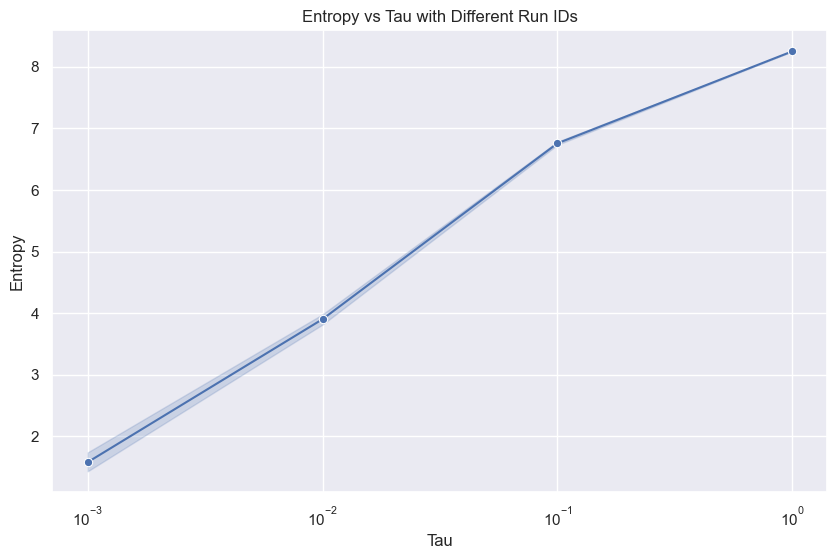

In [8]:
df = pd.DataFrame(records)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="tau", y="entropy", marker='o')

# Add labels and title
plt.xlabel('Tau')
plt.ylabel('Entropy')
plt.title('Entropy vs Tau with Different Run IDs')

# set x axis log
plt.xscale("log")

# Show the plot
plt.show()

In [42]:
rows, cols = 10, 10
start_state = (1, 1)
terminal_states = {(rows - 2, cols - 2): 1.0}
p_success = 1
seed = 3
run_id = 0

num_steps = 40_000
min_samples = 20
# min_samples = 0

# Learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.05  # Convergence criterion
tau = 100
batch_size = 32
train_max_iterations = 50
theta = 1e-6

env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))

In [43]:
tau = 1000
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = train_test_split(
    transitions_list, test_size=0.2, random_state=seed
)

random_policy_transitions = generate_transitions_observations(
    transitions_list,
    num_steps,
    tau=tau,
    min_samples=min_samples,
)


### Training
input_size = len(states[0])  # Or another way to represent the size of your input
output_size = len(actions)

# Initialize the DQN
qnet_random_policy = QNET(input_size, output_size)

# loss_record_random_policy = train_net_with_neural_fitting(
#     qnet_random_policy,
#     random_policy_transitions,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size,
#     train_max_iterations,
#     logger,
# )

In [44]:
tau = 0.1
seed_everything(run_id)
env = make_env(rows, cols, start_state, p_success, terminal_states, run_id)

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))
random_policy = create_random_policy(states, actions)
Q = {state: {action: 0 for action in actions} for state in states}
Q_pi_random = random_policy_evaluation_q_stochastic(
    states, actions, random_policy, Q, env.mdp, gamma, epsilon
)

transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

transitions_train, transitions_val = generate_train_test_split_with_valid_path(
    transitions_list=transitions_list,
    start_state=start_state,
    terminal_states=terminal_states,
    seed=run_id,
)

train_dataset_transitions = generate_transitions_observations(
    transitions_train, num_steps, tau=tau, min_samples=min_samples
)
from scipy.stats import entropy

freq_factors = get_frequency_scaling(train_dataset_transitions)
# print(freq_factors)
examples_normalized = [
    (transition[0], transition[1]) for transition in train_dataset_transitions
]
example_strings_normalized = [
    f"{state}_{action}" for state, action in examples_normalized
]
unique_examples, counts = np.unique(example_strings_normalized, return_counts=True)
print(counts)

print()

normed_dataset = normalize_frequencies(train_dataset_transitions)
normed_freq_factors = get_frequency_scaling(normed_dataset)
# print(normed_freq_factors)
examples_normalized = [(transition[0], transition[1]) for transition in normed_dataset]
example_strings_normalized = [
    f"{state}_{action}" for state, action in examples_normalized
]
unique_examples, counts = np.unique(example_strings_normalized, return_counts=True)
print(counts)


# random_policy_transitions = generate_random_policy_transitions(
#     transitions_train, num_steps, env, actions
# )

# seed_everything(seed)

# ### Training
# input_size = len(states[0])  # Or another way to represent the size of your input
# output_size = len(actions)

# # Initialize the DQN
# qnet_random_policy = QNET(input_size, output_size)

# loss_record = train_net_with_neural_fitted_q(
#     qnet_random_policy,
#     random_policy_transitions,
#     Q_pi_random,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size=batch_size,
#     max_iterations=train_max_iterations,
#     frequency_scaling=False,
#     logger=None,
# )

[  20   20   21   20   41   95   22   20  557   20  103  164  217  209
  857  292  440   20   48   20   27   54  220  103  148   39   25   21
   21   28   89   22  511   29   64   93  704  729   20  843  253   24
   20   21   50   55   20  688   20   22   20   46   22   23   20   36
   20   20   34   31   40  704   22   20  287   22   25   20  242   20
   53   23   21   22  261  333  179   20   21   20   20   23   41   24
   20  673   20   23   75   20  666   20   24  161   41   20   24   21
   20   24  618   20   21  191   20   74   20   20  171   23   22   20
   20   34   47  960   40   31  635   20   20   38   22   20   52   20
   86   20   55   53  952  150   78   20   42  561   24   20   20   20
  226  100   20  570   35   20   41  310   22   23   68   22   20   96
   20   20   32   64  687   20   27   20   20  411   79  828  650   91
   20  904   20   21   30   44   24   21  799   20   20  391   20   60
  543   20   34   23  435   70   20   34   20   28  865  119   27  488
   20 

In [45]:
max_iterations = 10
transitions = random_policy_transitions

net = QNET(input_size, output_size)
if logger is None:
    logger = logging.getLogger(__name__)

net.train()
dataset = TransitionDataset(transitions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loss_record = []

for epoch in range(max_iterations):
    total_loss = 0
    for state, action, next_state, reward, done in dataloader:
        optimizer.zero_grad()
        q_values = net(state)
        next_q_values = net(next_state)
        max_next_q_values = next_q_values.detach().max(1)[0]

        target_q_values_for_actions = reward + gamma * max_next_q_values * (~done)

        action_q_values = q_values.gather(1, action.unsqueeze(-1))

        loss = loss_fn(action_q_values, target_q_values_for_actions.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        break
    break

NameError: name 'logger' is not defined

In [ ]:
action_q_values.shape

torch.Size([32, 1])

In [ ]:
q_values.shape

torch.Size([32, 4])

In [ ]:
loss

tensor(0.7741, grad_fn=<MseLossBackward0>)

In [ ]:
q_values.gather(1, action.unsqueeze(-1)).shape

torch.Size([32, 1])

In [ ]:
def softmax(logits, tau):
    logits = np.array(logits)  # Ensure logits is a NumPy array for consistency
    logits -= np.max(logits)  # Improves numerical stability
    exp_logits = np.exp(logits / tau)
    softmax_probs = exp_logits / np.sum(exp_logits)
    return softmax_probs


def generate_transitions_observations(
    transitions_list, num_steps, tau, min_samples=None
):
    dset_size = len(transitions_list)

    # Validate min_samples if provided
    if min_samples is not None:
        if not isinstance(min_samples, int):
            raise ValueError("min_samples must be an integer")
        if min_samples * dset_size > num_steps:
            raise ValueError(
                "min_samples times length of transitions exceeds num_steps"
            )

        # Directly select each element in transitions_list min_samples times, considering their structure
        repeated_transitions = [
            transition for transition in transitions_list for _ in range(min_samples)
        ]
        remaining_steps = num_steps - (min_samples * dset_size)
    else:
        repeated_transitions = []
        remaining_steps = num_steps

    sampled_transitions = (
        repeated_transitions  # Start with the manually repeated transitions
    )

    if remaining_steps > 0:
        # Prepare logits for the softmax sampling; logits could be based on some criteria or just random
        logits = np.random.uniform(0, 1, size=dset_size)
        prob_dist = softmax(logits, tau)

        # Sample the remaining transitions based on the softmax distribution
        sampled_indices = np.random.choice(
            dset_size, size=remaining_steps, p=prob_dist, replace=True
        )
        sampled_transitions += [transitions_list[i] for i in sampled_indices]

    return sampled_transitions

In [ ]:
def get_freq_scaling(gen):
    transition_counts = Counter(gen)

    # Calculate expected frequency under uniform distribution
    N_total = len(transitions)
    N_unique = len(set(gen))
    expected_frequency = N_total / N_unique

    # Compute scaling factor relative to uniform distribution
    inverse_frequency_scaling = {
        t: expected_frequency / count for t, count in transition_counts.items()
    }
    return inverse_frequency_scaling

In [ ]:
transitions = [i for i in range(400)]

gen = generate_transitions_observations(
    transitions, num_steps=40_000, tau=1e30, min_samples=10
)
scaling = Counter(gen)

minimum_freq = min(scaling.values())
maximum_freq = max(scaling.values())

print(minimum_freq)
print(maximum_freq)

79
138


In [ ]:
logits = np.random.uniform(0, 1, size=len(transitions))
prob_dist = softmax(logits, tau=100)
prob_dist

array([0.00249136, 0.00250664, 0.00249756, 0.00249202, 0.00249281,
       0.00248853, 0.0024886 , 0.00250517, 0.00250314, 0.00250934,
       0.00250584, 0.00251034, 0.00251067, 0.00248909, 0.00250112,
       0.00250186, 0.00248831, 0.00248776, 0.00250646, 0.00250619,
       0.00250725, 0.00250653, 0.00250277, 0.00249907, 0.00250682,
       0.00250226, 0.00251183, 0.00248767, 0.00250952, 0.00248894,
       0.00251227, 0.0024928 , 0.00250414, 0.00250495, 0.00249739,
       0.00249633, 0.00249662, 0.00250939, 0.00249308, 0.00250685,
       0.00249795, 0.00250527, 0.00249277, 0.00249339, 0.00250964,
       0.00250537, 0.00251213, 0.00249768, 0.00250348, 0.00250299,
       0.00249657, 0.00250805, 0.00250233, 0.00251197, 0.00250898,
       0.0025039 , 0.00250408, 0.00249371, 0.00249871, 0.00249676,
       0.00250539, 0.00249965, 0.00249966, 0.00250149, 0.00249759,
       0.00249083, 0.00250176, 0.00251129, 0.00250244, 0.00249053,
       0.00250413, 0.00249954, 0.0025    , 0.00249317, 0.00248

In [ ]:
sampled_indices = np.random.choice(
    transitions, size=40_000_000, p=prob_dist, replace=True
)
sampled_indices

counts = Counter(sampled_indices)

minimum_freq = min(counts.values())
maximum_freq = max(counts.values())

print(minimum_freq)
print(maximum_freq)

98801
101007


In [ ]:
scaling

Counter({163: 5,
         276: 5,
         44: 4,
         182: 4,
         77: 4,
         257: 4,
         59: 4,
         267: 3,
         362: 3,
         269: 3,
         105: 3,
         252: 3,
         282: 3,
         283: 3,
         62: 3,
         324: 3,
         3: 3,
         94: 3,
         110: 3,
         399: 3,
         219: 3,
         26: 3,
         294: 3,
         370: 3,
         256: 3,
         325: 3,
         58: 3,
         205: 3,
         36: 3,
         13: 3,
         209: 3,
         347: 3,
         96: 2,
         106: 2,
         303: 2,
         321: 2,
         5: 2,
         208: 2,
         338: 2,
         162: 2,
         87: 2,
         48: 2,
         118: 2,
         119: 2,
         53: 2,
         297: 2,
         359: 2,
         349: 2,
         144: 2,
         150: 2,
         291: 2,
         389: 2,
         142: 2,
         253: 2,
         232: 2,
         311: 2,
         272: 2,
         225: 2,
         207: 2,
         185: 

In [ ]:
sampled_indices

array([267, 362,  96, 106, 358, 243, 303,  44, 321,   5, 182, 208,  24,
        29, 338, 269, 162, 321, 105, 227, 352, 146, 165,  45,  87, 132,
       293, 361, 252,  48, 118, 176, 119, 374, 258,  53, 145,  61, 375,
       282, 268, 387, 297, 125, 222,  87, 359, 182, 282, 349, 144, 163,
       267, 283,  62, 150, 324,   3,  16,  69,  94, 110, 291, 389, 142,
       253, 232, 399,  67, 103, 219, 172, 359, 311, 208, 272, 273, 225,
       207,  53, 185, 220, 386, 181, 285,  63, 147, 324, 345, 360, 269,
       225, 189, 115, 365, 219, 300,  77, 126, 126,  26, 294,  35, 389,
       128,  71,   6,  14, 107, 370,  17,  60, 348, 144,  65, 231, 379,
       148, 155,  84, 115, 290,  47,  72,   5, 322, 355,  68, 180, 272,
       256, 169,  82, 182, 319, 325, 256, 377,  92, 399,  54,  48, 188,
       218, 283, 318, 338, 134, 339, 368, 252,  66, 175, 370,  32, 391,
        44, 231,  21, 349, 163,  51, 333,  44, 297, 311, 230, 382, 245,
       267, 322, 325,  77,  84, 194, 226, 135, 190,  95, 184, 16

In [ ]:
max_next_q_values * (~done.unsqueeze(1))

NameError: name 'max_next_q_values' is not defined

In [ ]:
q_values.gather(1, action.unsqueeze(-1))

tensor([[ 1.3246],
        [-0.7336],
        [ 0.6904],
        [ 0.0315],
        [ 1.4223],
        [ 0.0071],
        [-0.0206],
        [-1.7084],
        [ 0.1359],
        [ 1.1714],
        [ 0.1897],
        [ 0.0509],
        [ 1.7091],
        [ 0.0664],
        [-1.0759],
        [ 0.8194],
        [-1.2782],
        [-0.4596],
        [ 0.6318],
        [-0.0032],
        [-1.5888],
        [ 0.8822],
        [-0.1998],
        [-1.2811],
        [-1.3465],
        [ 0.9563],
        [ 0.4550],
        [ 0.8518],
        [-0.6650],
        [ 1.4859],
        [-1.2025],
        [ 0.2654]], grad_fn=<GatherBackward0>)

In [ ]:
action

tensor([0, 1, 3, 2, 3, 2, 2, 1, 2, 0, 2, 2, 0, 2, 1, 3, 1, 1, 2, 2, 1, 3, 1, 1,
        1, 2, 2, 0, 1, 0, 1, 3])

In [ ]:
net(state).shape

torch.Size([32, 4])